In [129]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [130]:
df_charging = pd.read_pickle("data/charging_modified.pkl")

# Get number of stations per site
stations_per_site = df_charging.groupby('siteID')['stationID'].nunique()

In [131]:
# Earliest connectTime of siteID == 1 and siteID == 2
df_charging[df_charging['siteID'].isin([1, 2])].groupby('siteID')['connectionTime'].min()


siteID
1   2018-09-05 11:04:13+00:00
2   2018-04-25 11:08:04+00:00
Name: connectionTime, dtype: datetime64[ns, UTC]

# Settings


In [132]:
# Time Interval
start_date = "2018-09-04"
end_date = "2018-09-14"

#start_date = df_charging['connectionTime'].min().strftime('%Y-%m-%d')
#end_date = df_charging['disconnectTime'].max().strftime('%Y-%m-%d')

start_date_time = pd.to_datetime(start_date)
end_date_time = pd.to_datetime(end_date) + pd.Timedelta('1 day') - pd.Timedelta('1 second')

### 1) Utilization Rates per Station

**We currently calculate this per minute as evs can be connected during an hour and be connected less than an hour. So breaking it down to an hour is a bit inaccurate, if you want fast computation for lage chunks replace the ('T') with ('H')**

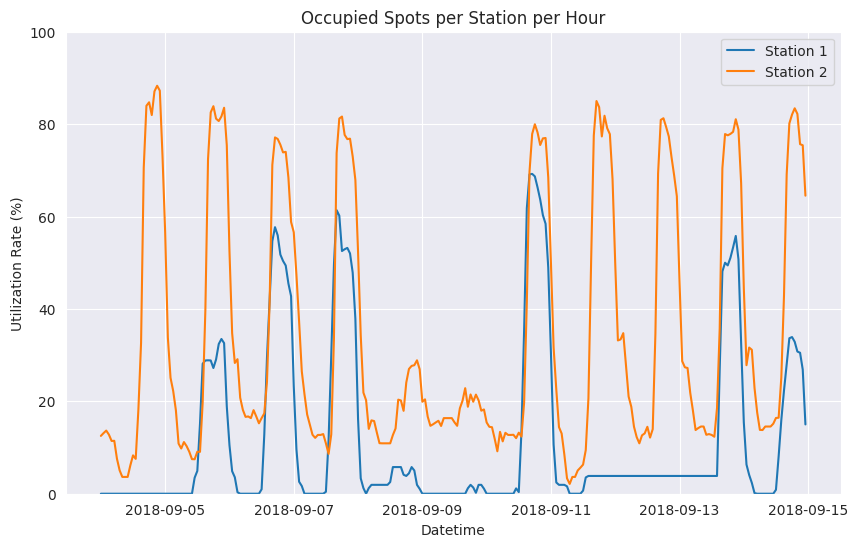

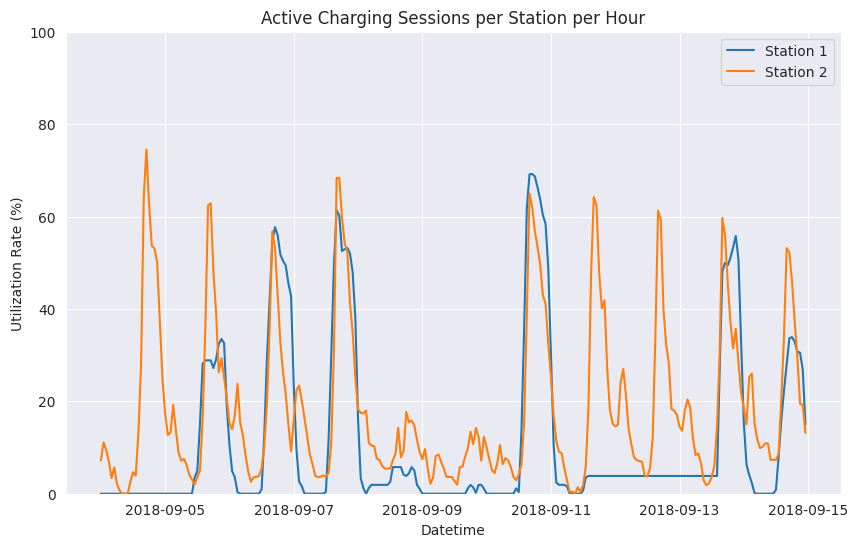

In [133]:

# Granularity of the utilization rate
granularity = 'T' # T is for minute, H is for hour

# Generate df with each row representing a minute in the time interval
df_time_interval = pd.date_range(start=start_date_time, end=end_date_time, freq=granularity)
df_time_interval = pd.DataFrame(df_time_interval, columns=['datetime'])
df_time_interval['datetime'] = pd.to_datetime(df_time_interval['datetime'], utc=True)

# Resample connectionTime and disconnectTime to full minutes, e.g., 10:31:20 -> 10:31:00
df_charging['connectionTime'] = df_charging['connectionTime'].dt.floor(granularity)
df_charging['disconnectTime'] = df_charging['disconnectTime'].dt.floor(granularity)

def count_sessions_total_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['disconnectTime'] >= point_in_time )]
    return filtered_df.shape[0]

def count_sessions_active_charging_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['disconnectTime'] >= point_in_time) & ((data['doneChargingTime'].isna()) | (data['doneChargingTime'] >= point_in_time))]
    return filtered_df.shape[0]

for site_id, data in df_charging.groupby('siteID'):
    df_time_interval[f'site{site_id}_total_count'] = df_time_interval['datetime'].apply(lambda datetime: count_sessions_total_at_point_in_time(data, datetime))
    df_time_interval[f'site{site_id}_charging_count'] = df_time_interval['datetime'].apply(lambda datetime: count_sessions_active_charging_at_point_in_time(data, datetime))

# Calculate the utilization rate for each station in minute
for site_id in stations_per_site.index:
    df_time_interval[f'site{site_id}_utilizationRate'] = (df_time_interval[f'site{site_id}_total_count'] / stations_per_site[site_id]) * 100
    df_time_interval[f'site{site_id}_utilizationRate_charging'] = (df_time_interval[f'site{site_id}_charging_count'] / stations_per_site[site_id]) * 100

df_time_interval = df_time_interval.set_index('datetime')
df_time_interval = df_time_interval.resample('H').mean()

def plot(df, title, y_column):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Datetime')
    plt.ylabel('Utilization Rate (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # Iterate over each station
    for site_id in stations_per_site.index:
        plt.plot(df.index, df[f'site{site_id}_{y_column}'], label=f'Station {site_id}')
    plt.legend()
    plt.show()

plot(df_time_interval, 'Occupied Spots per Station per Hour', 'utilizationRate')
plot(df_time_interval, 'Active Charging Sessions per Station per Hour', 'utilizationRate_charging')

# kWh Delivered per Station per Hour

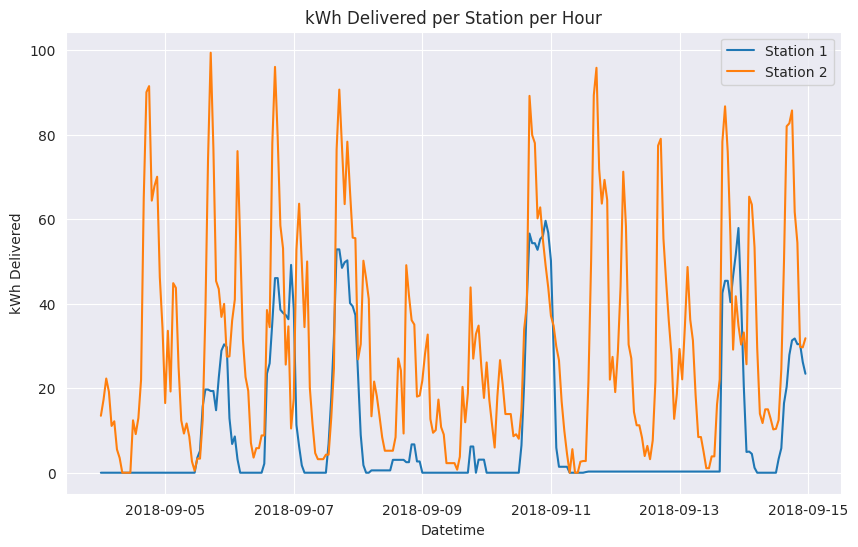

In [134]:
# Create time intervals
df_time_interval = pd.date_range(start=start_date_time, end=end_date_time, freq='H')
df_time_interval = pd.DataFrame(df_time_interval, columns=['datetime'])
df_time_interval['datetime'] = pd.to_datetime(df_time_interval['datetime'], utc=True)

# If doneChargingTime is NaN, the car is still charging, but here we can set it to the disconnectTime, as we are interested in the kWh delivered
df_charging['doneChargingTime'] = df_charging['doneChargingTime'].fillna(df_charging['disconnectTime'])

# Display charging sessions that are active at a given point in time
def count_kwh_delivered_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp):
    filtered_df = data[(data['connectionTime'] <= point_in_time) & (data['doneChargingTime'] >= point_in_time)]
    return (filtered_df['kWhDelivered'] / filtered_df['ChargingTimeHours']).sum()

for site_id, data in df_charging.groupby('siteID'):
    df_time_interval[f'site{site_id}_kwhDelivered'] = df_time_interval['datetime'].apply(lambda datetime: count_kwh_delivered_at_point_in_time(data, datetime))

df_time_interval = df_time_interval.set_index('datetime')

plt.figure(figsize=(10, 6))
plt.title('kWh Delivered per Station per Hour')
plt.xlabel('Datetime')
plt.ylabel('kWh Delivered')
plt.grid(True)

# Iterate over each station
for site_id in stations_per_site.index:
    plt.plot(df_time_interval.index, df_time_interval[f'site{site_id}_kwhDelivered'], label=f'Station {site_id}')
plt.legend()
plt.show()

### 3) Arrivals and Departures per Station per Hour

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,weekday,fullyCharged,...,kWhPerMinute,month,userRegistered,user_paymentRequired_values,user_requestedDeparture,user_minutesAvailable,user_milesRequested,user_kWhRequested,user_WhPerMile,user_kWhRequestFulfilment
0,2018-04-25 11:00:00+00:00,2018-04-25 13:00:00+00:00,2018-04-25 13:21:10+00:00,7.932,2,CA-496,2-39-78-362,NaN,Wednesday,True,...,0.059594,4,False,False,None,NaN,NaN,NaN,NaN,NaN
1,2018-04-25 13:00:00+00:00,2018-04-26 00:00:00+00:00,2018-04-25 16:44:15+00:00,10.013,2,CA-319,2-39-95-27,NaN,Wednesday,True,...,0.055913,4,False,False,None,NaN,NaN,NaN,NaN,NaN
2,2018-04-25 13:00:00+00:00,2018-04-25 23:00:00+00:00,2018-04-25 14:51:44+00:00,5.257,2,CA-489,2-39-79-380,NaN,Wednesday,True,...,0.079772,4,False,False,None,NaN,NaN,NaN,NaN,NaN
3,2018-04-25 14:00:00+00:00,2018-04-25 23:00:00+00:00,2018-04-25 16:05:22+00:00,5.177,2,CA-327,2-39-79-379,NaN,Wednesday,True,...,0.058652,4,False,False,None,NaN,NaN,NaN,NaN,NaN
4,2018-04-25 14:00:00+00:00,2018-04-25 23:00:00+00:00,2018-04-25 17:40:30+00:00,10.119,2,CA-490,2-39-79-381,NaN,Wednesday,True,...,0.056237,4,False,False,None,NaN,NaN,NaN,NaN,NaN


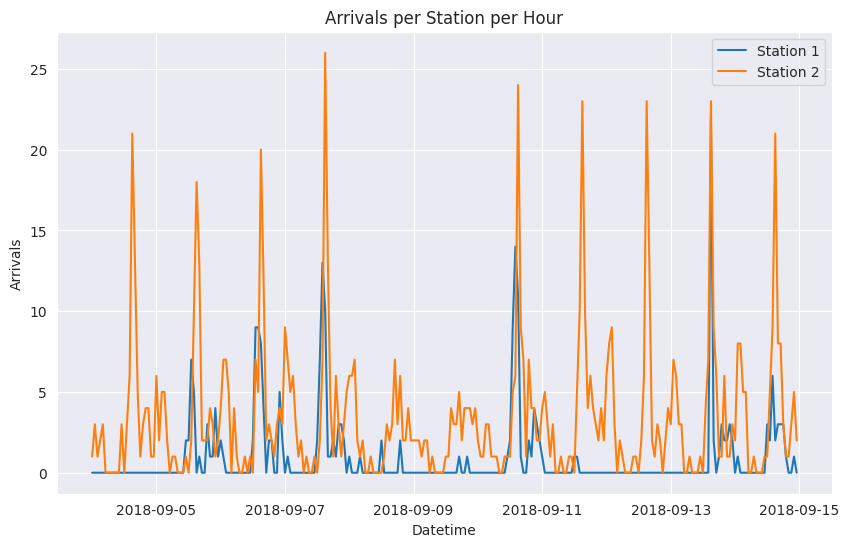

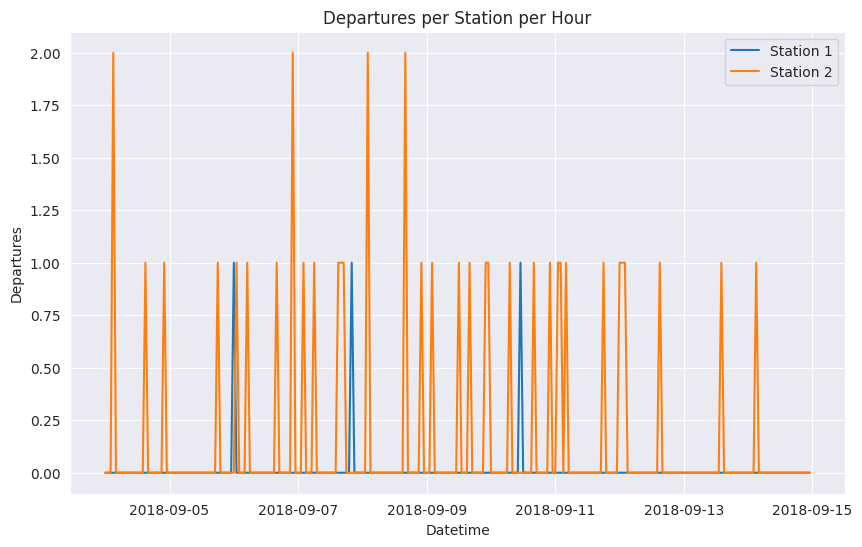

In [139]:
# Create time intervals
df_time_interval = pd.date_range(start=start_date_time, end=end_date_time, freq='H')
df_time_interval = pd.DataFrame(df_time_interval, columns=['datetime'])
df_time_interval['datetime'] = pd.to_datetime(df_time_interval['datetime'], utc=True)

df_charging_connectionTime = df_charging.copy()
df_charging_connectionTime['connectionTime'] = df_charging_connectionTime['connectionTime'].dt.floor('H')
df_charging_connectionTime['disconnectTime'] = df_charging_connectionTime['disconnectTime'].dt.floor('H')
display(df_charging_connectionTime.head())

# Display charging sessions that start at a given time
def count_at_point_in_time(data: pd.DataFrame, point_in_time: pd.Timestamp, column_name: str):
    filtered_df = data[(data[column_name] <= point_in_time) & (data['connectionTime'] + pd.Timedelta('1 second') > point_in_time)]
    return filtered_df.shape[0]

for site_id, data in df_charging_connectionTime.groupby('siteID'):
    df_time_interval[f'site{site_id}_arrivals'] = df_time_interval['datetime'].apply(lambda datetime: count_at_point_in_time(data, datetime, 'connectionTime'))
    df_time_interval[f'site{site_id}_departures'] = df_time_interval['datetime'].apply(lambda datetime: count_at_point_in_time(data, datetime, 'disconnectTime'))
    
df_time_interval = df_time_interval.set_index('datetime')

plt.figure(figsize=(10, 6))
plt.title('Arrivals per Station per Hour')
plt.xlabel('Datetime')
plt.ylabel('Arrivals')
plt.grid(True)

# Iterate over each station
for site_id in stations_per_site.index:
    plt.plot(df_time_interval.index, df_time_interval[f'site{site_id}_arrivals'], label=f'Station {site_id}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.title('Departures per Station per Hour')
plt.xlabel('Datetime')
plt.ylabel('Departures')
plt.grid(True)

# Iterate over each station
for site_id in stations_per_site.index:
    plt.plot(df_time_interval.index, df_time_interval[f'site{site_id}_departures'], label=f'Station {site_id}')
plt.legend()
plt.show()